# Hypothesis

Dimensions with high saliencies significantly contribute to performance of VespaG.

## Experiment

Bin dimensions based on percentiles of the distribution of the average saliencies. For each bin, set the embeddings of the corresponding dimensions to zero. Test how setting these dimensions to zero influences the performance of VespaG. Evaluate this by considering the spearman correlation between the VespaG and Gemme scores. 

- First do this experiment with C_atrox as a sanity check 
- Then apply pipeline on entire PLA2 dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import h5py
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import sys 
sys.path.append('../vespag')

from parse.vep_scores import get_vespag_scores, get_gemme_scores

### Pipeline using C_atrox

#### Load Saliencies

In [3]:
saliency_map = np.load('../output_c_atrox/MF974418_1_Crotalus_atrox_saliency.npy')
# Dimension of saliency maps: (sequence length, mutations, embedding dimensions)
print(saliency_map.shape)

(122, 20, 2560)


#### Calculate average saliency per dimension

In [4]:
# calculate mean saliency for each embedding dimension
mean_saliency_per_dim = np.mean(saliency_map, axis=(0, 1))
assert mean_saliency_per_dim.shape == (2560,)

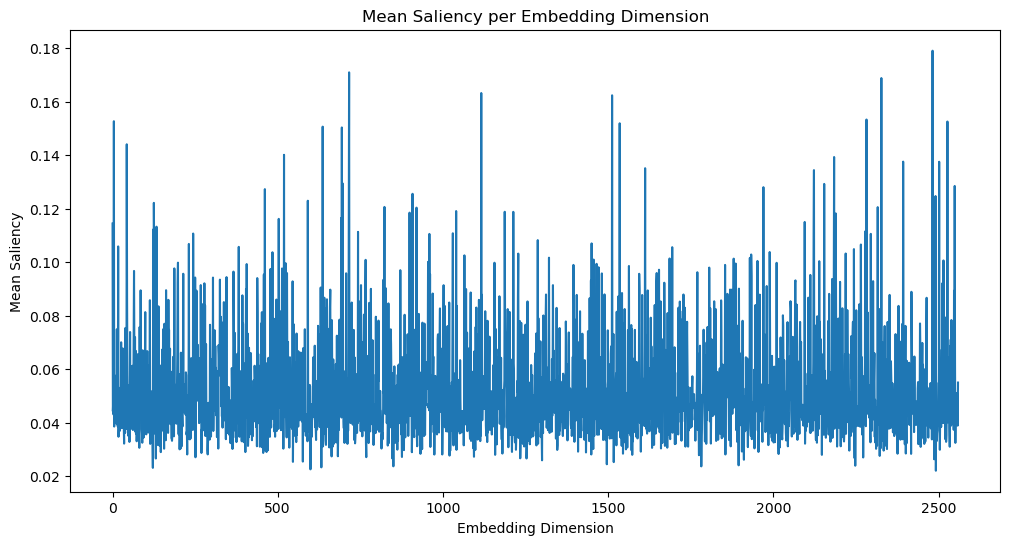

In [67]:
# plot the mean saliency for each embedding dimension
plt.figure(figsize=(12, 6))
plt.plot(mean_saliency_per_dim, label="Mean")
plt.title("Mean Saliency per Embedding Dimension")
plt.xlabel("Embedding Dimension")
plt.ylabel("Mean Saliency")
plt.show()

In [191]:
# Define percentiles
percentiles = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
percentile_values = np.percentile(mean_saliency_per_dim, percentiles)

c = 0  
bins = {}  

for i in range(len(percentiles) - 1):
    lower_bound = percentile_values[i]
    upper_bound = percentile_values[i + 1]

    # Find indices of elements within this percentile range
    bin_indices = np.where((mean_saliency_per_dim >= lower_bound) & (mean_saliency_per_dim < upper_bound))[0]
    bins[f"{percentiles[i]}-{percentiles[i+1]}"] = bin_indices 

    num_dims = len(bin_indices)
    c += num_dims
    
    print(f"Number of dimensions in {percentiles[i]}-{percentiles[i+1]}th percentile: {num_dims}")

# Last bin (99-100th percentile)
bin_indices_last = np.where(mean_saliency_per_dim >= percentile_values[-1])[0]
bins[f"{percentiles[-1]}-100"] = bin_indices_last 

num_dims_last = len(bin_indices_last)
c += num_dims_last

print(f"Number of dimensions in {percentiles[-1]}-100th percentile: {num_dims_last}")
assert c == mean_saliency_per_dim.shape[0], "Error: Total count does not match!"

Number of dimensions in 0-5th percentile: 128
Number of dimensions in 5-10th percentile: 128
Number of dimensions in 10-15th percentile: 128
Number of dimensions in 15-20th percentile: 128
Number of dimensions in 20-25th percentile: 128
Number of dimensions in 25-30th percentile: 128
Number of dimensions in 30-35th percentile: 128
Number of dimensions in 35-40th percentile: 128
Number of dimensions in 40-45th percentile: 128
Number of dimensions in 45-50th percentile: 128
Number of dimensions in 50-55th percentile: 128
Number of dimensions in 55-60th percentile: 128
Number of dimensions in 60-65th percentile: 128
Number of dimensions in 65-70th percentile: 128
Number of dimensions in 70-75th percentile: 128
Number of dimensions in 75-80th percentile: 128
Number of dimensions in 80-85th percentile: 128
Number of dimensions in 85-90th percentile: 128
Number of dimensions in 90-95th percentile: 128
Number of dimensions in 95-100th percentile: 128


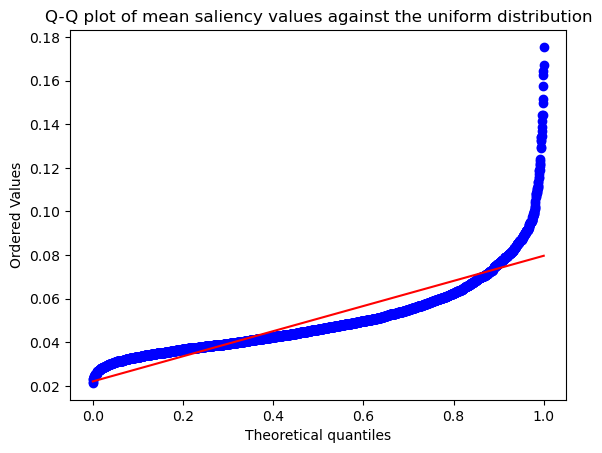

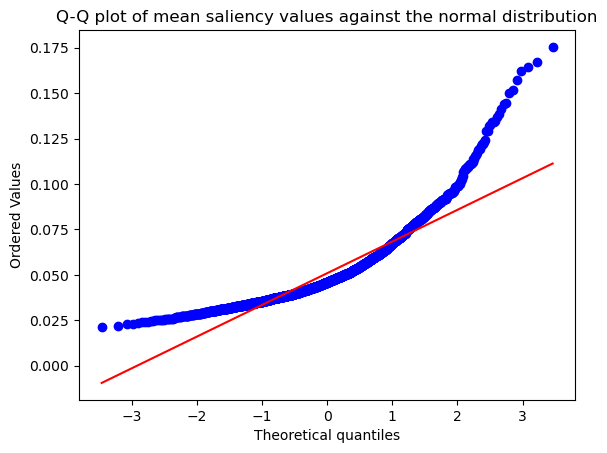

In [192]:
import scipy.stats as stats

# double check that the mean saliency values are uniformly distributed
stats.probplot(mean_saliency_per_dim, dist="uniform", plot=plt)
plt.title("Q-Q plot of mean saliency values against the uniform distribution")
plt.show()

stats.probplot(mean_saliency_per_dim, dist="norm", plot=plt)
plt.title("Q-Q plot of mean saliency values against the normal distribution")
plt.show()

Yea, except for the lower and upper bound, the saliencies are uniformly distributed. 

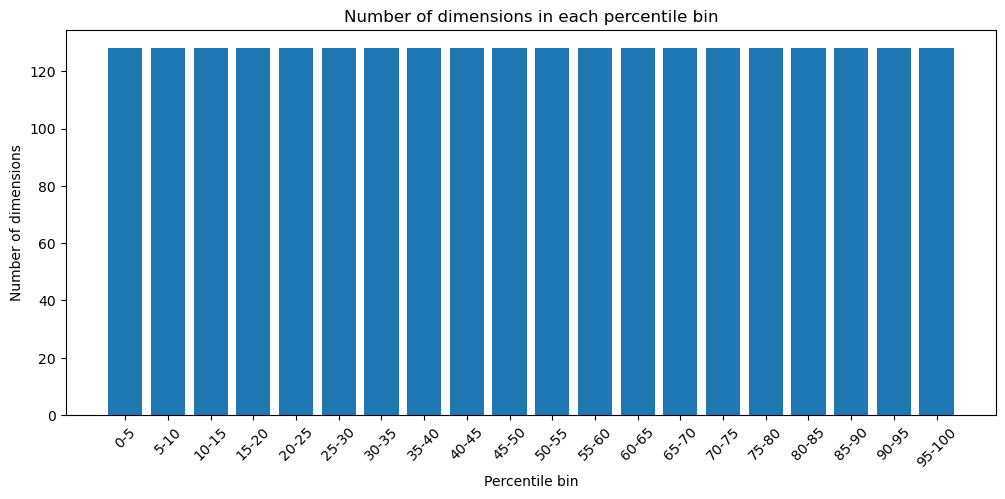

In [194]:
plt.figure(figsize=(12, 5))
plt.bar(range(len(bins)), [len(bins[k]) for k in bins.keys()])
plt.xticks(range(len(bins)), bins.keys(), rotation=45)
plt.ylabel("Number of dimensions")
plt.xlabel("Percentile bin")
plt.title("Number of dimensions in each percentile bin")
plt.show()

#### For each of the bins, set the embedding values of all of the dimensions to zero. 

In [4]:
# laod the embeddings 
embedding_file = '/mnt/c/Users/nicol/Documents/thesis/VespaG/output_c_atrox/esm2_embeddings.h5'

with h5py.File(embedding_file, 'r') as f:
    protein_id = list(f.keys())[0]
    embedding = f[protein_id][()]
    embedding = torch.tensor(embedding)

protein_id, embedding.shape

('MF974418_1_Crotalus_atrox', torch.Size([122, 2560]))

In [196]:
modified_values = [0, 0.25, 0.5, 0.75, 1, 1.5, 2] 

modified_embeddings_folder = '/mnt/f/nicole/modified_binned_embeddings_c_atrox/'
os.makedirs(modified_embeddings_folder, exist_ok=True)

# for each of the bins, set the embeddings to the modified value and store the embeddings in a new .h5 file 
for modified_value in modified_values:
    for bin_name, bin_indices in tqdm(bins.items()):
        bin_name = bin_name.replace('-', '_')
        modified_embedding = embedding.clone()
        modified_embedding[:, bin_indices] = modified_value
        modified_embedding_file = os.path.join(modified_embeddings_folder, f'modified_embedding_value={modified_value}_bin={bin_name}.h5')
        with h5py.File(modified_embedding_file, 'w') as f:
            f.create_dataset(protein_id, data=modified_embedding.numpy())

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:01<00:00, 16.66it/s]


#### Off screen: Generate VespaG predictions for these bins

#### Load the Original and Modified VespaG results and the Gemme results. 

In [239]:
vespag_folders = '/mnt/f/nicole/output_c_atrox_modified_binned/'

folders = os.listdir(vespag_folders)

modified_results = []

for folder in tqdm(folders, desc="Processing folders", unit="folder"):
    # get the modified value and dimension from the folder name
    config = folder.replace("modified_embedding_", '')
    modified_value, bin = config.split('_bin=')
    bin = bin.replace('_', '-')
    modified_value = modified_value.replace('value=', '')
    
    # get the vespag results file in the folder
    files = os.listdir(os.path.join(vespag_folders, folder))
    assert len(files) == 1, f"Expected 1 file in folder {folder}, got {len(files)}"

    vespag_path = os.path.join(vespag_folders, folder, files[0])
    vespag_scores = get_vespag_scores(vespag_path)
    vespag_scores = vespag_scores.rename(columns={'vespag': 'modified_vespag'})
    vespag_scores['modified_value'] = modified_value
    vespag_scores['bin'] = bin

    # store the results  
    modified_results.append(vespag_scores)

print('Concatenating results')
modified_results = pd.concat(modified_results)
print('Getting the mutation effect')
modified_results['modified_mutation_effect'] = - modified_results['modified_vespag']
# normalize the mutation effect into [0,1]
print('Normalizing the mutation effect')
modified_results['modified_norm_mutational_effect'] = (modified_results.modified_mutation_effect - modified_results.modified_mutation_effect.min()) / (modified_results.modified_mutation_effect.max() - modified_results.modified_mutation_effect.min())
print('Shape of the dataframe: ', modified_results.shape)
modified_results.head()

Processing folders:   0%|          | 0/140 [00:00<?, ?folder/s]

Processing folders: 100%|██████████| 140/140 [00:01<00:00, 86.34folder/s]


Concatenating results
Getting the mutation effect
Normalizing the mutation effect
Shape of the dataframe:  (324520, 7)


,residue,mutation,modified_vespag,modified_value,bin,modified_mutation_effect,modified_norm_mutational_effect
0,S1,S1A,-2.784549,0.25,0-5,2.784549,0.470303
1,S1,S1Y,-4.586318,0.25,0-5,4.586318,0.586167
2,S1,S1W,-4.902360,0.25,0-5,4.902360,0.606491
3,S1,S1V,-4.399762,0.25,0-5,4.399762,0.574171
4,S1,S1T,-2.377631,0.25,0-5,2.377631,0.444136


In [240]:
modified_results[['modified_value', 'bin']].drop_duplicates().shape

(140, 2)

In [241]:
# simplify the dataframe 
modified_results = modified_results[['residue', 'mutation', 'modified_value', 'bin', 'modified_norm_mutational_effect']]
modified_results = modified_results.rename(columns={'modified_norm_mutational_effect': 'modified_vespag'})
modified_results.head()

,residue,mutation,modified_value,bin,modified_vespag
0,S1,S1A,0.25,0-5,0.470303
1,S1,S1Y,0.25,0-5,0.586167
2,S1,S1W,0.25,0-5,0.606491
3,S1,S1V,0.25,0-5,0.574171
4,S1,S1T,0.25,0-5,0.444136


In [242]:
# load the original vespag results
vespag_path = '/mnt/f/nicole/pla2_vespag/MF974418_1_Crotalus_atrox.csv'
original_vespag_result = get_vespag_scores(vespag_path)
original_vespag_result['mutation_effect'] = - original_vespag_result['vespag']
original_vespag_result['original_vespag'] = (original_vespag_result['mutation_effect'] - original_vespag_result['mutation_effect'].min()) / (original_vespag_result['mutation_effect'].max() - original_vespag_result['mutation_effect'].min())

# merge the original and modified results
modified_scores = pd.merge(modified_results, original_vespag_result.drop(['vespag', 'mutation_effect'], axis=1), on=['residue', 'mutation'])

# load the gemme results 
gemme_path = '/mnt/f/nicole/pla2_gemme/MF974418_1_Crotalus_atrox/MF974418_1_Crotalus_atrox_normPred_evolCombi.txt'
gemme_scores = get_gemme_scores(gemme_path)
gemme_scores['mutation_effect'] = - gemme_scores['gemme']
gemme_scores['gemme'] = (gemme_scores['mutation_effect'] - gemme_scores['mutation_effect'].min()) / (gemme_scores['mutation_effect'].max() - gemme_scores['mutation_effect'].min())

# merge the results 
modified_scores = pd.merge(modified_scores, gemme_scores[['residue', 'mutation', 'gemme']], on=['residue', 'mutation'])
print(modified_scores.shape)
modified_scores.head()

(324520, 7)


,residue,mutation,modified_value,bin,modified_vespag,original_vespag,gemme
0,S1,S1A,0.25,0-5,0.470303,0.338812,0.101697
1,S1,S1Y,0.25,0-5,0.586167,0.595842,0.354269
2,S1,S1W,0.25,0-5,0.606491,0.639421,0.354269
3,S1,S1V,0.25,0-5,0.574171,0.557678,0.354269
4,S1,S1T,0.25,0-5,0.444136,0.291791,0.228835


In [243]:
# for each of the modified batches, calculate the spearman correlation between results and the gemme results
# store the results for plotting later on 
correlations = []

def calculate_spearman_correlation(group):
    return group['modified_vespag'].corr(group['gemme'], method='spearman')

correlations = modified_scores.groupby(['bin', 'modified_value']).apply(calculate_spearman_correlation).reset_index(name='spearman_correlation')
correlations['spearman_correlation'] = correlations['spearman_correlation'].abs()
correlations.head()

/tmp/ipykernel_354588/1058813514.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations = modified_scores.groupby(['bin', 'modified_value']).apply(calculate_spearman_correlation).reset_index(name='spearman_correlation')


,bin,modified_value,spearman_correlation
0,0-5,0,0.884103
1,0-5,0.25,0.886943
2,0-5,0.5,0.885669
3,0-5,0.75,0.881348
4,0-5,1,0.874371


In [244]:
baseline_correlation = modified_scores['original_vespag'].corr(modified_scores['gemme'], method='spearman')
baseline_correlation

0.8860354761462542

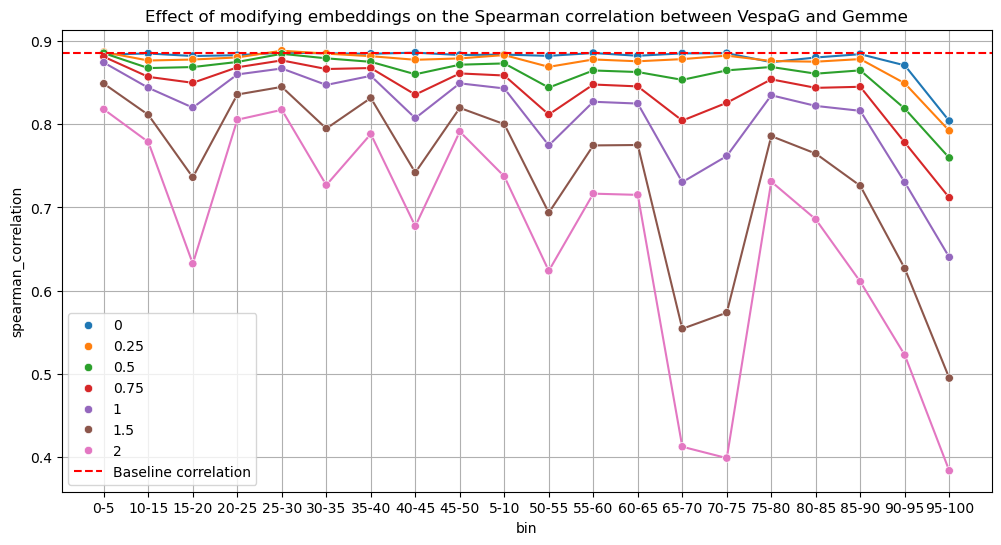

In [245]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=correlations, x='bin', y='spearman_correlation', hue='modified_value', palette='tab10', zorder=2)
sns.scatterplot(data=correlations, x='bin', y='spearman_correlation', hue='modified_value', palette='tab10', zorder=2)
plt.axhline(y=baseline_correlation, color='r', linestyle='--', label='Baseline correlation', zorder=2)
plt.title('Effect of modifying embeddings on the Spearman correlation between VespaG and Gemme')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.grid(zorder=0)
plt.show()

### Generalize over the entire PLA2 dataset

#### Load Saliencies

In [5]:
wildtype_dimension = 0
mutant_dimension = 1
embeddings_dimension = 2

In [6]:
saliency_folder = '/mnt/f/nicole/pla2_saliency'

mean_array = np.zeros((2560,)) 
files = [file for file in os.listdir(saliency_folder) if file.endswith('.npy')]

# load each numpy object in the saliency folder 
for file in tqdm(files, unit='file', desc="Loading saliencies"):
    id = file.split('.npy')[0]
    saliency = np.load(os.path.join(saliency_folder, file))
    # reduce the saliency to the average per embedding dimension 
    mean_saliency_per_dim = saliency.mean(axis=(wildtype_dimension, mutant_dimension)) # (2560,)

    # calculate the sem of the saliency
    sem_saliency_per_dim = np.std(saliency, axis=(wildtype_dimension, mutant_dimension)) / np.sqrt(saliency.shape[wildtype_dimension] * saliency.shape[mutant_dimension])
    mean_array += mean_saliency_per_dim

mean_array /= len(files)

Loading saliencies: 100%|██████████| 524/524 [12:16<00:00,  1.41s/file]


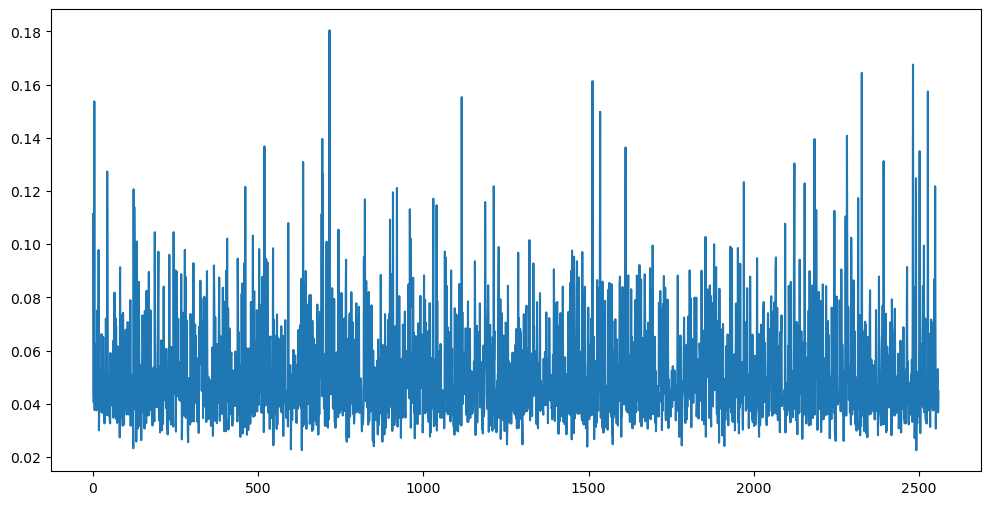

In [36]:
# plot the mean saliency for each embedding dimension
plt.figure(figsize=(12, 6))
plt.plot(mean_array, label="Mean")
plt.show()

In [37]:
mean_array.shape

(2560,)

In [38]:
# Define percentiles
percentiles = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
percentile_values = np.percentile(mean_saliency_per_dim, percentiles)

c = 0  
bins = {}  

for i in range(len(percentiles) - 1):
    lower_bound = percentile_values[i]
    upper_bound = percentile_values[i + 1]

    # Find indices of elements within this percentile range
    bin_indices = np.where((mean_saliency_per_dim >= lower_bound) & (mean_saliency_per_dim < upper_bound))[0]
    bins[f"{percentiles[i]}-{percentiles[i+1]}"] = bin_indices 

    num_dims = len(bin_indices)
    c += num_dims
    
    print(f"Number of dimensions in {percentiles[i]}-{percentiles[i+1]}th percentile: {num_dims}")

# Last bin (99-100th percentile)
bin_indices_last = np.where(mean_saliency_per_dim >= percentile_values[-1])[0]
bins[f"{percentiles[-1]}-100"] = bin_indices_last 

num_dims_last = len(bin_indices_last)
c += num_dims_last

print(f"Number of dimensions in {percentiles[-1]}-100th percentile: {num_dims_last}")
assert c == mean_saliency_per_dim.shape[0], "Error: Total count does not match!"

Number of dimensions in 0-5th percentile: 128
Number of dimensions in 5-10th percentile: 128
Number of dimensions in 10-15th percentile: 128
Number of dimensions in 15-20th percentile: 128
Number of dimensions in 20-25th percentile: 128
Number of dimensions in 25-30th percentile: 128
Number of dimensions in 30-35th percentile: 128
Number of dimensions in 35-40th percentile: 128
Number of dimensions in 40-45th percentile: 128
Number of dimensions in 45-50th percentile: 128
Number of dimensions in 50-55th percentile: 128
Number of dimensions in 55-60th percentile: 128
Number of dimensions in 60-65th percentile: 128
Number of dimensions in 65-70th percentile: 128
Number of dimensions in 70-75th percentile: 128
Number of dimensions in 75-80th percentile: 128
Number of dimensions in 80-85th percentile: 128
Number of dimensions in 85-90th percentile: 128
Number of dimensions in 90-95th percentile: 128
Number of dimensions in 95-100th percentile: 128


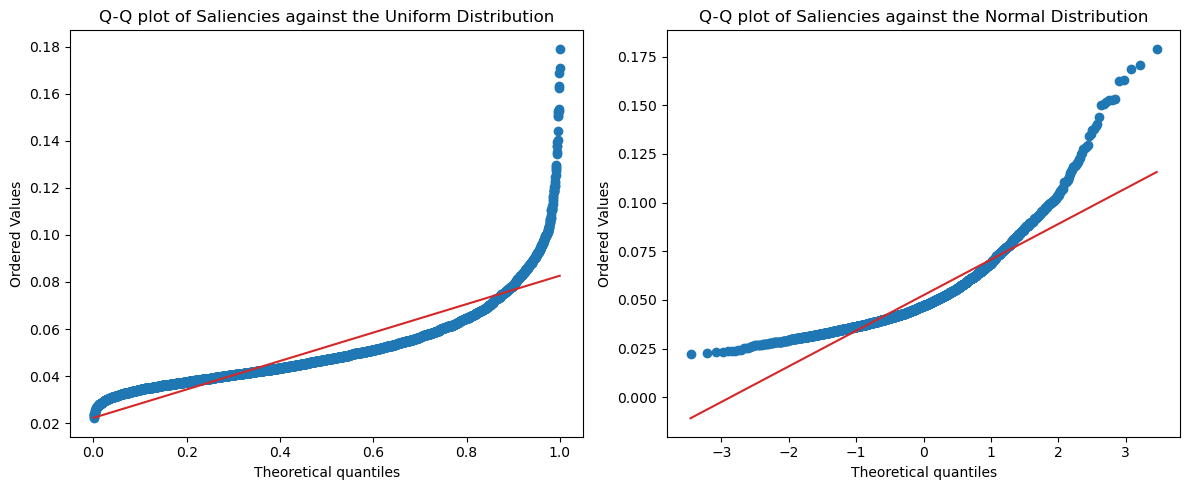

In [118]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Create a figure with two subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Q-Q plot against the **Uniform Distribution**
stats.probplot(mean_saliency_per_dim, dist="uniform", plot=axes[0])
axes[0].get_lines()[0].set_color("tab:blue") 
axes[0].get_lines()[1].set_color("tab:red")
axes[0].set_title("Q-Q plot of Saliencies against the Uniform Distribution")

# Q-Q plot against the **Normal Distribution**
stats.probplot(mean_saliency_per_dim, dist="norm", plot=axes[1])
axes[1].get_lines()[0].set_color("tab:blue")
axes[1].get_lines()[1].set_color("tab:red")
axes[1].set_title("Q-Q plot of Saliencies against the Normal Distribution")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


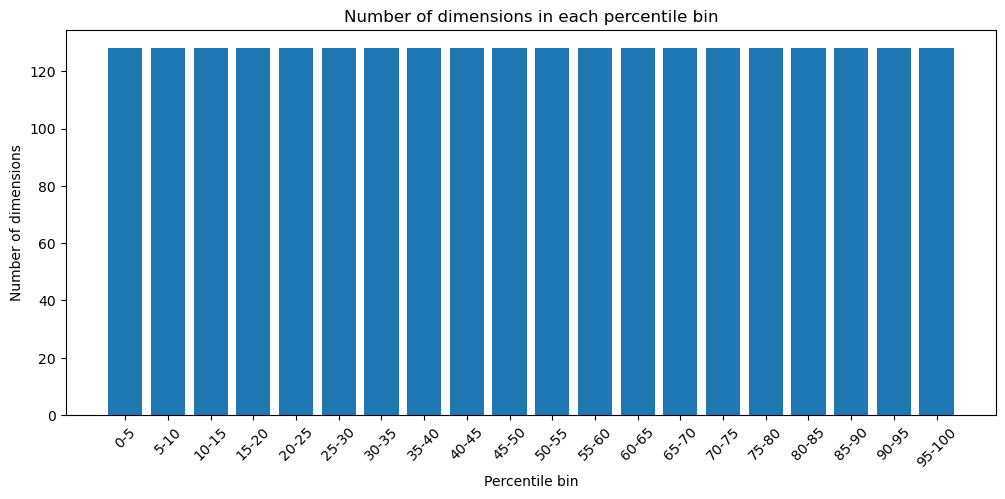

In [217]:
plt.figure(figsize=(12, 5))
plt.bar(range(len(bins)), [len(bins[k]) for k in bins.keys()])
plt.xticks(range(len(bins)), bins.keys(), rotation=45)
plt.ylabel("Number of dimensions")
plt.xlabel("Percentile bin")
plt.title("Number of dimensions in each percentile bin")
plt.show()

#### Everything checks out for the mean over all saliencies as well :) 

#### Set the embeddings of the embedding values of all of the dimensions to different values as well 

In [ ]:
embedding_file = '/mnt/f/nicole/embeddings/pla2_esm2_embeddings.h5'
modified_values = [0, 0.25, 0.5, 0.75, 1, 1.5, 2]

modified_embeddings_folder = '/mnt/f/nicole/modified_binned_embeddings_pla2/'
os.makedirs(modified_embeddings_folder, exist_ok=True)

# Open the original h5 file
with h5py.File(embedding_file, 'r') as f:
    protein_ids = list(f.keys())

    # Iterate over each bin and modified value to create separate h5 files
    for modified_value in modified_values:
        for bin_name, bin_indices in bins.items():
            bin_name = bin_name.replace('-', '_')

            # Define output file name for this configuration
            modified_embedding_file = os.path.join(
                modified_embeddings_folder,
                f'modified_embedding_value={modified_value}_bin={bin_name}.h5'
            )

            # Create a new .h5 file for this configuration
            with h5py.File(modified_embedding_file, 'w') as f_out:
                for protein_id in tqdm(protein_ids, desc=f"Processing {bin_name} - {modified_value}"):
                    embedding = torch.tensor(f[protein_id][()])  
                    
                    modified_embedding = embedding.clone()
                    modified_embedding[:, bin_indices] = modified_value  

                    # Store the modified embedding under the protein ID
                    f_out.create_dataset(protein_id, data=modified_embedding.numpy())

print("All modified embeddings have been stored in separate configuration files.")

Processing 95_100 - 2: 100%|██████████| 524/524 [00:11<00:00, 47.23it/s]


All modified embeddings have been stored in separate configuration files.


#### Off screen: Generate VespaG predictions for these bins for the entire PLA2 dataset

#### Load the original and modified VespaG results and the Gemme results

In [3]:
from parse.vep_scores import load_vespag_scores_from_folder, load_gemme_scores_from_folder

Because of memory restrictions we cannot load all VespaG results at once and then calculate the correlations etc. We have to load one batch of VespaG results and then reduce to the correlation towards the gemme results right away.

In [10]:
# load the original vespag results 
vespag_path = '/mnt/f/nicole/pla2_vespag/'
original_vespag_result = load_vespag_scores_from_folder(vespag_path)
original_vespag_result['mutation_effect'] = - original_vespag_result['vespag']
original_vespag_result['original_vespag'] = (original_vespag_result['mutation_effect'] - original_vespag_result['mutation_effect'].min()) / (original_vespag_result['mutation_effect'].max() - original_vespag_result['mutation_effect'].min())

# load the gemme results 
gemme_path = '/mnt/f/nicole/pla2_gemme/'
gemme_scores = load_gemme_scores_from_folder(gemme_path)
gemme_scores['mutation_effect'] = - gemme_scores['gemme']
gemme_scores['gemme'] = (gemme_scores['mutation_effect'] - gemme_scores['mutation_effect'].min()) / (gemme_scores['mutation_effect'].max() - gemme_scores['mutation_effect'].min())

# merge the results
original_scores = pd.merge(original_vespag_result.drop(['vespag', 'mutation_effect'], axis=1), gemme_scores.drop(['mutation_effect'], axis=1), on=['id', 'residue', 'mutation'])
print(original_scores.shape, gemme_scores.shape, original_vespag_result.shape)
original_scores.head()

Loading Gemme scores: 100%|██████████| 524/524 [00:06<00:00, 77.22folder/s]


(1222099, 5) (1222099, 5) (1222099, 6)


,residue,mutation,id,original_vespag,gemme
0,N1,N1A,AY355170_1_sistruxin_B_Sistrurus_tergeminus,0.364656,0.387672
1,N1,N1Y,AY355170_1_sistruxin_B_Sistrurus_tergeminus,0.493063,0.387672
2,N1,N1W,AY355170_1_sistruxin_B_Sistrurus_tergeminus,0.530656,0.387672
3,N1,N1V,AY355170_1_sistruxin_B_Sistrurus_tergeminus,0.471612,0.387672
4,N1,N1T,AY355170_1_sistruxin_B_Sistrurus_tergeminus,0.343762,0.387672


In [11]:
# calculate the spearman correlation between the original vespag and gemme results
baseline_correlation = original_scores['original_vespag'].corr(original_scores['gemme'], method='spearman')
baseline_correlation

0.8713651003766191

In [12]:
gemme_scores.head()

,residue,mutation,gemme,id,mutation_effect
0,N1,N1A,0.39324,AY355169_1_Sistrurus_tergeminus,2.116094
1,N1,N1V,0.39324,AY355169_1_Sistrurus_tergeminus,2.116094
2,N1,N1T,0.39324,AY355169_1_Sistrurus_tergeminus,2.116094
3,N1,N1S,0.39324,AY355169_1_Sistrurus_tergeminus,2.116094
4,N1,N1R,0.39324,AY355169_1_Sistrurus_tergeminus,2.116094


In [83]:
vespag_folders = '/mnt/f/nicole/output_pla2_modified_binned/'
folders = os.listdir(vespag_folders)

correlations = []

for folder in tqdm(folders, desc="Processing folders", unit="folder"):
    # get the modified value and dimension from the folder name
    config = folder.replace("modified_embedding_", '')
    modified_value, bin = config.split('_bin=')
    bin = bin.replace('_', '-')
    modified_value = modified_value.replace('value=', '')

    vespag_scores = load_vespag_scores_from_folder(os.path.join(vespag_folders, folder))
    vespag_scores = vespag_scores.rename(columns={'vespag': 'modified_vespag'})
    vespag_scores['modified_value'] = modified_value
    vespag_scores['bin'] = bin

    # preprocessing 
    vespag_scores['modified_mutation_effect'] = - vespag_scores['modified_vespag']
    vespag_scores['modified_norm_mutational_effect'] = (vespag_scores.modified_mutation_effect - vespag_scores.modified_mutation_effect.min()) / (vespag_scores.modified_mutation_effect.max() - vespag_scores.modified_mutation_effect.min())

    # merge the gemme results
    modified_results = pd.merge(vespag_scores, gemme_scores[['id', 'residue', 'mutation', 'gemme']], on=['id', 'residue', 'mutation'])
    assert modified_results.shape[0] == vespag_scores.shape[0] and modified_results.shape[0] == gemme_scores.shape[0]

    # calculate the spearman correlation
    spearman_correlation = modified_results['modified_norm_mutational_effect'].corr(modified_results['gemme'], method='spearman')
    spearman_correlation = abs(spearman_correlation)

    # store the results
    correlations.append({
        'bin': bin,
        'modified_value': modified_value,
        'spearman_correlation': spearman_correlation
    })

correlations = pd.DataFrame(correlations)
correlations.head()

Processing folders:   0%|          | 0/140 [00:00<?, ?folder/s]

Processing folders: 100%|██████████| 140/140 [29:18<00:00, 12.56s/folder]


,bin,modified_value,spearman_correlation
0,0-5,0.25,0.869678
1,10-15,0.25,0.868101
2,15-20,0.25,0.865481
3,20-25,0.25,0.866310
4,25-30,0.25,0.865560


In [98]:
correlations['lower_bound'] = correlations['bin'].apply(lambda x: int(x.split('-')[0]))
correlations.head()

,bin,modified_value,spearman_correlation,lower_bound
0,0-5,0.25,0.869678,0
1,10-15,0.25,0.868101,10
2,15-20,0.25,0.865481,15
3,20-25,0.25,0.866310,20
4,25-30,0.25,0.865560,25


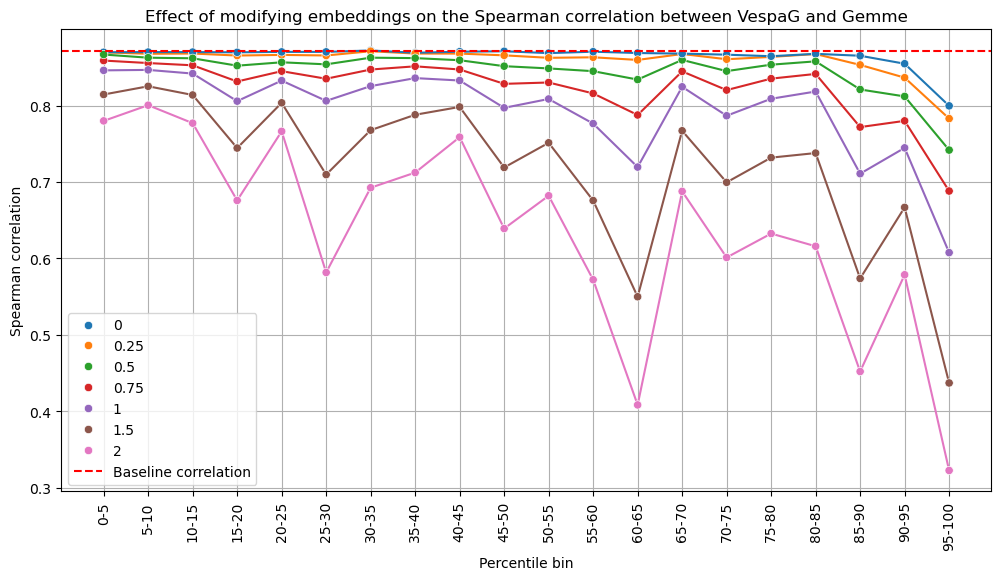

In [101]:
correlations['lower_bound'] = correlations['bin'].apply(lambda x: int(x.split('-')[0]))
correlations = correlations.sort_values('lower_bound')

# ensure same color map as before
color_mapping = {
    '0': 'tab:blue',
    '0.25': 'tab:orange',
    '0.5': 'tab:green',
    '0.75': 'tab:red',
    '1': 'tab:purple',
    '1.5': 'tab:brown',
    '2': 'tab:pink'
}
plt.figure(figsize=(12, 6))
order = correlations.lower_bound.sort_values().index
sns.lineplot(data=correlations, x='bin', y='spearman_correlation', hue='modified_value', palette=color_mapping, zorder=2)
sns.scatterplot(data=correlations, x='bin', y='spearman_correlation', hue='modified_value', palette=color_mapping, zorder=2)
plt.axhline(y=baseline_correlation, color='r', linestyle='--', label='Baseline correlation', zorder=2)
plt.title('Effect of modifying embeddings on the Spearman correlation between VespaG and Gemme')

# Fix legend order manually to fit first plot
handles, labels = plt.gca().get_legend_handles_labels()
legend_dict = dict(zip(labels, handles))  # Remove duplicates

sorted_legend_items = sorted(
    legend_dict.items(), key=lambda x: float(x[0]) if x[0].replace('.', '', 1).isdigit() else float('inf')
)
sorted_labels, sorted_handles = zip(*sorted_legend_items)

plt.legend(sorted_handles, sorted_labels)
plt.ylabel("Spearman correlation")
plt.xlabel("Percentile bin")
plt.xticks(rotation=90)
plt.grid(zorder=0)
plt.show()

### Invert the experiment

From the PLA results we can see that especially the dimensions in the 85 percentile of the saliencies have the largest effect on the performance of VespaG. 

Now invert the experiment, meaning that I will set all other dimensions to zero and then consider the performance of VespaG. 



In [57]:
# select the 85 quantile of the saliencies 
q85 = np.percentile(mean_saliency_per_dim, 85)
dimensions = np.where(mean_saliency_per_dim >= q85)[0]
modify_dimensions = np.where(mean_saliency_per_dim < q85)[0]
assert len(modify_dimensions) + len(dimensions) == mean_saliency_per_dim.shape[0]

In [64]:
embedding_file = '/mnt/f/nicole/embeddings/pla2_esm2_embeddings.h5'
modified_embeddings_folder = '/mnt/f/nicole/modified_inverted_embeddings_pla2/'
os.makedirs(modified_embeddings_folder, exist_ok=True)

modified_value = 0

percentiles = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 99]

for percentile in tqdm(percentiles, desc="Processing percentiles"):

    # quantile value
    q = np.percentile(mean_saliency_per_dim, percentile)
    modify_dimensions = np.where(mean_saliency_per_dim < q)[0]

    # open the original h5 file
    with h5py.File(embedding_file, 'r') as f:
        protein_ids = list(f.keys())

        # define output file name for this configuration
        modified_embedding_file = os.path.join(
            modified_embeddings_folder,
            f'modified_embedding_value={modified_value}_q{percentile}.h5'
        )

        # create a new .h5 file for this configuration
        with h5py.File(modified_embedding_file, 'w') as f_out:
            for protein_id in tqdm(protein_ids, desc=f"Processing proteins"):
                embedding = torch.tensor(f[protein_id][()])  

                modified_embedding = embedding.clone()
                modified_embedding[:, modify_dimensions] = modified_value  

                # store the modified embedding under the protein ID
                f_out.create_dataset(protein_id, data=modified_embedding.numpy())


Processing percentiles:   0%|          | 0/20 [00:00<?, ?it/s]

Processing percentiles: 100%|██████████| 20/20 [06:34<00:00, 19.71s/it]


#### Off Screen: Generate VespaG predictions

#### Load the results

In [104]:
# load the results 
vespag_folders = '/mnt/f/nicole/output_pla2_modified_inverted/'
folders = os.listdir(vespag_folders)

correlations_zero = []

for folder in tqdm(folders, desc="Processing folders", unit="folder"):
    # get the modified value and dimension from the folder name
    config = folder.replace("modified_embedding_", '')
    modified_value, percentile = config.split('_q')
    modified_value = modified_value.replace('value=', '')

    vespag_scores = load_vespag_scores_from_folder(os.path.join(vespag_folders, folder))
    vespag_scores = vespag_scores.rename(columns={'vespag': 'modified_vespag'})
    vespag_scores['modified_value'] = modified_value
    vespag_scores['percentile'] = percentile

    # preprocessing 
    vespag_scores['modified_mutation_effect'] = - vespag_scores['modified_vespag']
    vespag_scores['modified_norm_mutational_effect'] = (vespag_scores.modified_mutation_effect - vespag_scores.modified_mutation_effect.min()) / (vespag_scores.modified_mutation_effect.max() - vespag_scores.modified_mutation_effect.min())

    # merge the gemme results
    modified_results = pd.merge(vespag_scores, gemme_scores[['id', 'residue', 'mutation', 'gemme']], on=['id', 'residue', 'mutation'])
    assert modified_results.shape[0] == vespag_scores.shape[0] and modified_results.shape[0] == gemme_scores.shape[0]

    # calculate the spearman correlation
    spearman_correlation = modified_results['modified_norm_mutational_effect'].corr(modified_results['gemme'], method='spearman')
    spearman_correlation = abs(spearman_correlation)

    # store the results
    correlations_zero.append({
        'percentile': percentile,
        'modified_value': modified_value,
        'spearman_correlation': spearman_correlation
    })

correlations_zero = pd.DataFrame(correlations_zero)
correlations_zero.head()

Processing folders:   0%|          | 0/20 [00:00<?, ?folder/s]

Processing folders: 100%|██████████| 20/20 [04:16<00:00, 12.82s/folder]


,percentile,modified_value,spearman_correlation
0,10,0,0.868020
1,15,0,0.865984
2,20,0,0.863318
3,25,0,0.860904
4,30,0,0.858724


In [110]:
correlations_zero['percentile'] = correlations_zero['percentile'].astype(int)

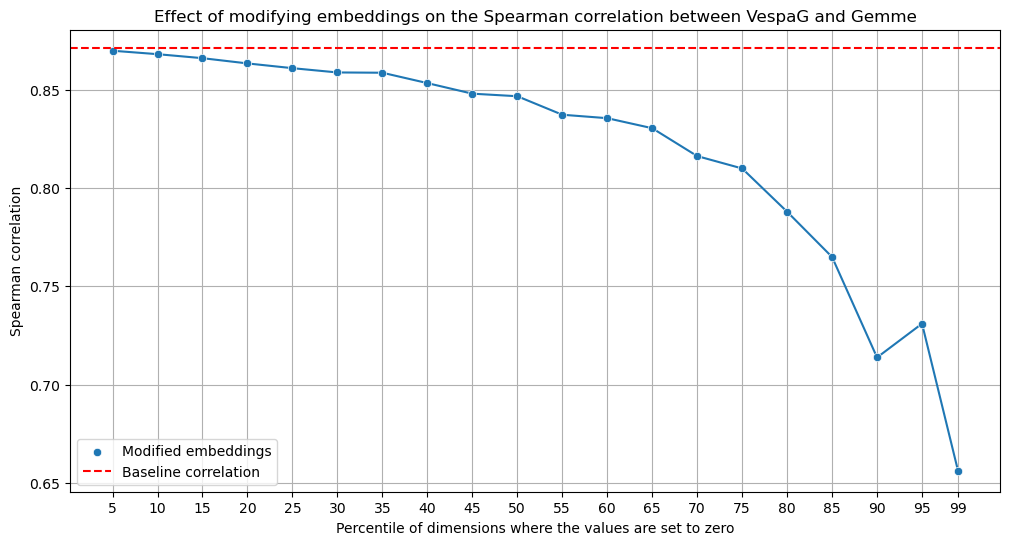

In [111]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=correlations_zero, x='percentile', y='spearman_correlation', zorder=2)
sns.scatterplot(data=correlations_zero, x='percentile', y='spearman_correlation', zorder=2, label='Modified embeddings')
plt.axhline(y=baseline_correlation, color='r', linestyle='--', label='Baseline correlation', zorder=2)
plt.xticks(correlations_zero['percentile'])
plt.title('Effect of modifying embeddings on the Spearman correlation between VespaG and Gemme')
plt.ylabel('Spearman correlation')
plt.xlabel('Percentile of dimensions where the values are set to zero')
plt.grid(zorder=0)
plt.legend()
plt.show()

In [114]:
percentile = 85
q = np.percentile(mean_saliency_per_dim, percentile)
np.where(mean_saliency_per_dim >= q)[0].shape

(384,)

In [112]:
correlations_zero.tail()

,percentile,modified_value,spearman_correlation
15,80,0,0.787897
16,85,0,0.764861
17,90,0,0.713771
18,95,0,0.730979
19,99,0,0.656178


In [113]:
baseline_correlation

0.8713651003766191

### Does this Generalize to the ProteinGym 217 Dataset?

Just the part with setting the dimensions with the hight saliencies to zero. Our assumption is, that the other steps generalize. 

In [4]:
proteingym_embeddings_file = '/mnt/f/nicole/proteingym_217_esm2.h5'
modified_embeddings_folder = '/mnt/f/nicole/modified_proteingym_217_embeddings/'
os.makedirs(modified_embeddings_folder, exist_ok=True)

modified_value = 0
percentiles = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 99]

for percentile in tqdm(percentiles, desc="Processing percentiles"):

    # quantile value of previous experiment
    q = np.percentile(mean_saliency_per_dim, percentile)
    modify_dimensions = np.where(mean_saliency_per_dim < q)[0]

    # open the original h5 file
    with h5py.File(proteingym_embeddings_file, 'r') as f:
        protein_ids = list(f.keys())

        # define output file name for this configuration
        modified_embedding_file = os.path.join(
            modified_embeddings_folder,
            f'modified_embedding_value={modified_value}_q{percentile}.h5'
        )

        # create a new .h5 file for this configuration
        with h5py.File(modified_embedding_file, 'w') as f_out:
            for protein_id in tqdm(protein_ids, desc=f"Processing proteins"):
                embedding = torch.tensor(f[protein_id][()])  

                modified_embedding = embedding.clone()
                modified_embedding[:, modify_dimensions] = modified_value  

                # store the modified embedding under the protein ID
                f_out.create_dataset(protein_id, data=modified_embedding.numpy())


Processing percentiles:   0%|          | 0/20 [00:00<?, ?it/s]


NameError: name 'mean_saliency_per_dim' is not defined

Generate vespag results off screen

In [ ]:
# load the vespag results and the gemme results 
vespag_path = '/mnt/f/nicole/proteingym_217_vespag/'

original_vespag_result = load_vespag_scores_from_folder(vespag_path)
original_vespag_result['mutation_effect'] = - original_vespag_result['vespag']
original_vespag_result['original_vespag'] = (original_vespag_result['mutation_effect'] - original_vespag_result['mutation_effect'].min()) / (original_vespag_result['mutation_effect'].max() - original_vespag_result['mutation_effect'].min())

gemme_path = '/mnt/f/nicole/proteingym_166_gemme/'
gemme_scores = load_gemme_scores_from_folder(gemme_path)
gemme_scores['mutation_effect'] = - gemme_scores['gemme']
gemme_scores['gemme'] = (gemme_scores['mutation_effect'] - gemme_scores['mutation_effect'].min()) / (gemme_scores['mutation_effect'].max() - gemme_scores['mutation_effect'].min())

# merge the results
original_scores = pd.merge(original_vespag_result.drop(['vespag', 'mutation_effect'], axis=1), gemme_scores.drop(['mutation_effect'], axis=1), on=['id', 'residue', 'mutation'])
original_scores.head()

Loading VespaG scores:   0%|          | 0/166 [00:00<?, ?file/s]

Loading Gemme scores: 100%|██████████| 166/166 [00:05<00:00, 31.99folder/s]


,residue,mutation,id,original_vespag,gemme
0,M1,M1A,A0A192B1T2_9HIV1,0.392495,0.665341
1,M1,M1Y,A0A192B1T2_9HIV1,0.370785,0.665341
2,M1,M1W,A0A192B1T2_9HIV1,0.371548,0.665341
3,M1,M1V,A0A192B1T2_9HIV1,0.295498,0.476272
4,M1,M1T,A0A192B1T2_9HIV1,0.386962,0.665341


In [16]:
baseline_correlation_proteingym = original_scores['original_vespag'].corr(original_scores['gemme'], method='spearman')
baseline_correlation_proteingym

0.7462097124809887

In [18]:
# load the results
path = '/mnt/f/nicole/modified_proteingym_166_vespag/'
folders = os.listdir(path)

correlations_proteingym = []

for folder in tqdm(folders, desc="Processing folders", unit="folder"):
    # get the modified value and dimension from the folder name
    config = folder.replace("modified_embedding_", '')
    modified_value, percentile = config.split('_q')
    modified_value = modified_value.replace('value=', '')

    vespag_scores = load_vespag_scores_from_folder(os.path.join(path, folder))
    vespag_scores = vespag_scores.rename(columns={'vespag': 'modified_vespag'})
    vespag_scores['modified_value'] = modified_value
    vespag_scores['percentile'] = percentile

    # preprocessing 
    vespag_scores['modified_mutation_effect'] = - vespag_scores['modified_vespag']
    vespag_scores['modified_norm_mutational_effect'] = (vespag_scores.modified_mutation_effect - vespag_scores.modified_mutation_effect.min()) / (vespag_scores.modified_mutation_effect.max() - vespag_scores.modified_mutation_effect.min())

    # merge the gemme results
    modified_results = pd.merge(vespag_scores, gemme_scores[['id', 'residue', 'mutation', 'gemme']], on=['id', 'residue', 'mutation'])
    assert modified_results.shape[0] == vespag_scores.shape[0] and modified_results.shape[0] == gemme_scores.shape[0]

    # calculate the spearman correlation
    spearman_correlation = modified_results['modified_norm_mutational_effect'].corr(modified_results['gemme'], method='spearman')
    spearman_correlation = abs(spearman_correlation)

    # store the results
    correlations_proteingym.append({
        'percentile': percentile,
        'modified_value': modified_value,
        'spearman_correlation': spearman_correlation
    })

correlations_proteingym = pd.DataFrame(correlations_proteingym)
correlations_proteingym.head()

Processing folders:   0%|          | 0/20 [00:00<?, ?folder/s]

Processing folders: 100%|██████████| 20/20 [01:19<00:00,  3.99s/folder]


,percentile,modified_value,spearman_correlation
0,10,0,0.742952
1,15,0,0.741292
2,20,0,0.738246
3,25,0,0.735450
4,30,0,0.731576


In [19]:
correlations_proteingym['percentile'] = correlations_proteingym['percentile'].astype(int)

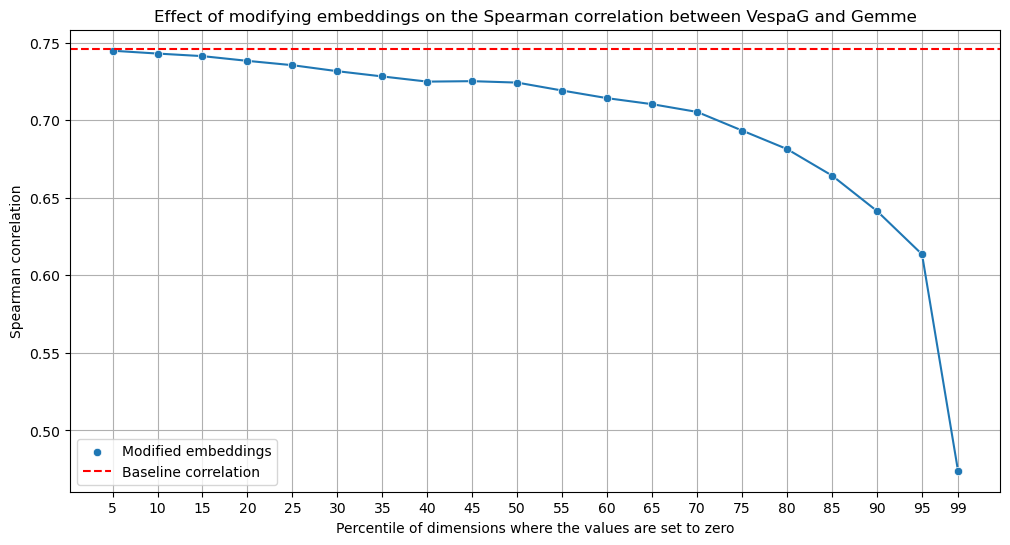

In [21]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=correlations_proteingym, x='percentile', y='spearman_correlation', zorder=2)
sns.scatterplot(data=correlations_proteingym, x='percentile', y='spearman_correlation', zorder=2, label='Modified embeddings')
plt.axhline(y=baseline_correlation_proteingym, color='r', linestyle='--', label='Baseline correlation', zorder=2)
plt.xticks(correlations_proteingym['percentile'])
plt.title('Effect of modifying embeddings on the Spearman correlation between VespaG and Gemme')
plt.ylabel('Spearman conrelation')
plt.xlabel('Percentile of dimensions where the values are set to zero')
plt.grid(zorder=0)
plt.legend()
plt.show()

### Can we cluster these dimensions by amino acid properties 

If we can cluster these dimensions by amino acid properties, we can hypothesis that this is what the model is learning

In [19]:
# select the Dimensions in the 95th percentile
q = 85
threshold = np.percentile(mean_saliency_per_dim, q)
dimensions = np.where(mean_saliency_per_dim >= threshold)[0]
print(dimensions.shape) 
print(dimensions)

(384,)
[   0    4   13   17   39   43   44   53   64   65   68   82   85   99
  113  123  125  126  127  129  130  133  139  153  157  162  169  171
  187  197  198  214  231  244  250  252  254  267  272  278  280  295
  304  309  325  328  330  334  336  337  344  345  366  367  370  382
  393  395  404  406  409  438  439  450  452  454  458  461  478  484
  488  496  503  509  513  519  524  525  528  545  548  557  582  591
  622  628  630  636  641  644  649  655  658  659  664  679  686  687
  692  694  696  707  715  716  723  724  730  743  750  752  761  765
  766  777  782  787  797  803  805  820  822  823  827  829  835  842
  871  884  893  897  899  903  904  908  914  915  920  927  938  944
  955  959  961  969  984  985  990  991 1002 1005 1014 1019 1029 1030
 1040 1042 1065 1068 1070 1073 1084 1099 1101 1106 1109 1116 1118 1128
 1135 1141 1156 1160 1171 1187 1188 1191 1196 1202 1213 1227 1228 1233
 1237 1243 1250 1256 1282 1287 1289 1295 1304 1311 1312 1321 1333 1344

In [20]:
proteingym_166_embedding_file = '/mnt/f/nicole/proteingym_166_vespag/esm2_embeddings.h5'
modified_embedding_file = f'/mnt/f/nicole/embeddings/proteingym_166_q{q}_dimensions.h5'
with h5py.File(proteingym_166_embedding_file, 'r') as f:
    # for each protein, select only the selected dimensions
    for protein_id in tqdm(f.keys(), desc="Processing proteins"):
        embedding = torch.tensor(f[protein_id][()])  
        modified_embedding = embedding[:, dimensions]

        # store the modified embedding
        with h5py.File(modified_embedding_file, 'a') as f_out:
            f_out.create_dataset(protein_id, data=modified_embedding.numpy())

Processing proteins:   0%|          | 0/166 [00:00<?, ?it/s]

Processing proteins: 100%|██████████| 166/166 [00:10<00:00, 15.77it/s]


In [21]:
# now do the same for the pla2 dataset 
pla2_embedding_file = '/mnt/f/nicole/embeddings/pla2_esm2_embeddings.h5'
modified_embedding_file = f'/mnt/f/nicole/embeddings/pla2_q{q}_dimensions.h5'
with h5py.File(pla2_embedding_file, 'r') as f:
    # for each protein, select only the selected dimensions
    for protein_id in tqdm(f.keys(), desc="Processing proteins"):
        embedding = torch.tensor(f[protein_id][()])  
        modified_embedding = embedding[:, dimensions]

        # store the modified embedding
        with h5py.File(modified_embedding_file, 'a') as f_out:
            f_out.create_dataset(protein_id, data=modified_embedding.numpy())

Processing proteins: 100%|██████████| 524/524 [00:18<00:00, 28.83it/s]
